In this project I will train an imgage classifier to recognize different species of flowers.

I will be using the Oxford flowers dataset.

Below are a few examples.


<img  src='assets/Flowers.png' width=500px>

The project is broken down into 3 steps:
1. Load the image dataset and create a pipeline.
2. Build and train an image classifier on the dataset.
3. Use the model to make predictions on a test set.

I will use Python and TensorFlow.

In [1]:
# Install Pytorch
!pip3 install torch torchvision torchaudio

In [2]:
# Import Torch
import torch
from torchvision import transforms, datasets, models

In [3]:
# Install TensorFlow transforms.
!pip3 install -q tensorflow-transform
import tensorflow_transform as tft

In [4]:
# Import TensorFlow.
import tensorflow as tf
import tensorflow_hub as hub 
import tensorflow_datasets as tfds

In [5]:
# Other imports.
import json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
# Matplotlib settings.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar() 

In [7]:
# Load and split the dataset.
oxford_flowers, info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)
print(oxford_flowers)

training, validation, test = oxford_flowers['train'], oxford_flowers['validation'], oxford_flowers['test']

{'test': <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'train': <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'validation': <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [8]:
# Normalize and resize all sets.
transformed_training = transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomCrop(224),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(), 
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])

transformed__validation = transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(0.485, 0.456, 0.406),
                                                                  (0.229, 0.224, 0.225)])

transformed_test = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225)])


In [9]:
# Explore the dataset.

# Print number of examples in each set.
print("Number of examples in training set:", len(training))
print("Number of examples in validation set:", len(validation))
print("Number of examples in test set:", len(test))
print('\n')

# Print datasetinfo.
print("Dataset info:", info)
print('\n')

# Print number of classes in dataset.
print("Number of classes in dataset:", len(oxford_flowers))
print('\n')

# Display the dataset.
oxford_flowers

Number of examples in training set: 1020
Number of examples in validation set: 1020
Number of examples in test set: 6149


Dataset info: tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(

{'test': <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'train': <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'validation': <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

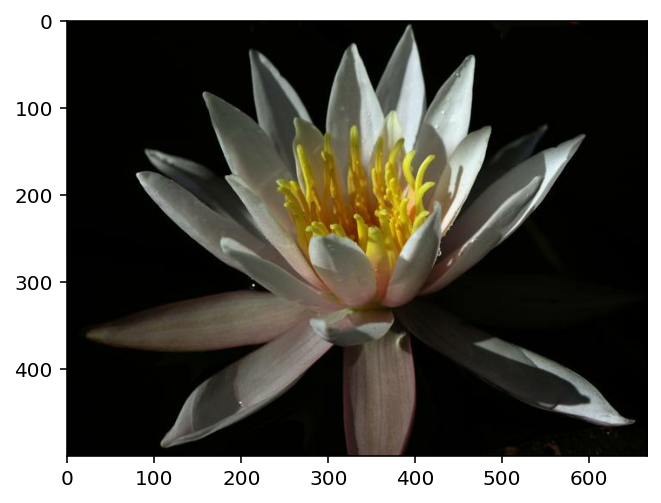

The shape of this image is: (500, 667, 3)
The label of this image is: 72


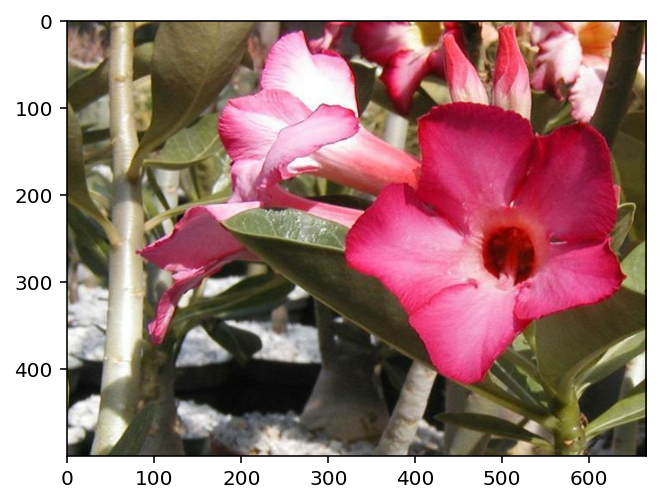

The shape of this image is: (500, 666, 3)
The label of this image is: 84


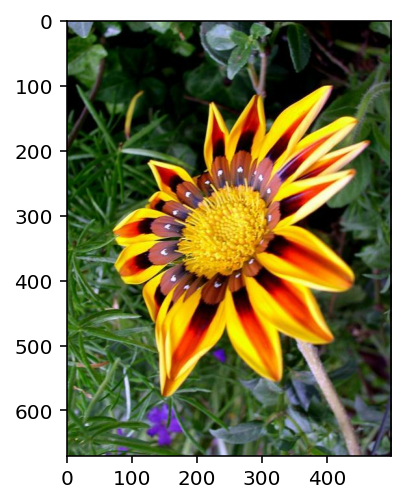

The shape of this image is: (670, 500, 3)
The label of this image is: 70


In [10]:
# Print the shape and labels of 3 train set imgages.
for image, label in training.take(3):
  image = image.numpy()
  label = label.numpy()

  plt.imshow(image)
  plt.show()

  print("The shape of this image is:", image.shape)
  print("The label of this image is:", label) 


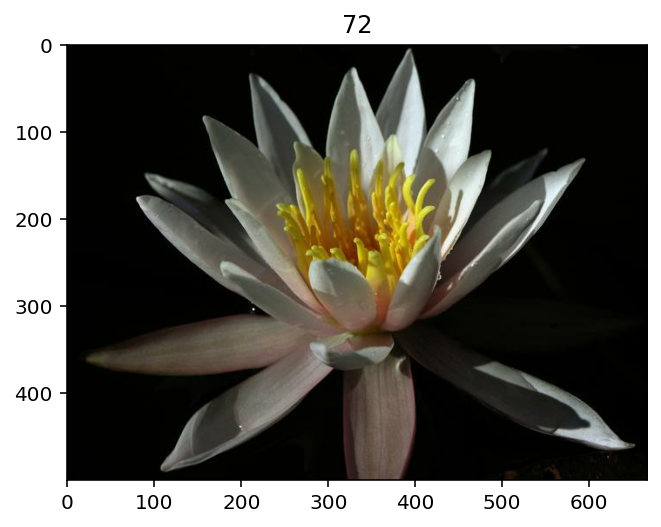

In [11]:
# Plot 1 image from train set and set the title as the image label.
for image, label in training.take(1):
  image = image.numpy()
  label = label.numpy()

  plt.imshow(image)
  plt.title(label)
                                

In [5]:
# Map labels to category name.
import json
with open('label_map.json', 'r') as f:
  class_names = json.load(f)

print("The class names are:", json.dumps(class_names, indent=4))

The class names are: {
    "21": "fire lily",
    "3": "canterbury bells",
    "45": "bolero deep blue",
    "1": "pink primrose",
    "34": "mexican aster",
    "27": "prince of wales feathers",
    "7": "moon orchid",
    "16": "globe-flower",
    "25": "grape hyacinth",
    "26": "corn poppy",
    "79": "toad lily",
    "39": "siam tulip",
    "24": "red ginger",
    "67": "spring crocus",
    "35": "alpine sea holly",
    "32": "garden phlox",
    "10": "globe thistle",
    "6": "tiger lily",
    "93": "ball moss",
    "33": "love in the mist",
    "9": "monkshood",
    "102": "blackberry lily",
    "14": "spear thistle",
    "19": "balloon flower",
    "100": "blanket flower",
    "13": "king protea",
    "49": "oxeye daisy",
    "15": "yellow iris",
    "61": "cautleya spicata",
    "31": "carnation",
    "64": "silverbush",
    "68": "bearded iris",
    "63": "black-eyed susan",
    "69": "windflower",
    "62": "japanese anemone",
    "20": "giant white arum lily",
    "38": "g